# Beer Challenge - VISIO
## Ricardo A. Araujo 

Summarizing it, we aim to count and compare dead and live cells in beer yeast samples, visuallized in Neubauer chambers amplified using a microscope.

At least, we could separate the challenge into some parts:
- Agregate all images in one, reconstructing the grid
- Preprocess the image to feature extraction
- Remove grid to improve results
- Count using Hough Transform

In [1]:
import numpy as np
import imageio as imgl
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
from sklearn import cluster
from time import perf_counter
from IPython.core.interactiveshell import InteractiveShell

mpl.rcParams['figure.figsize'] = (15,15)

In [2]:
def load_imageset(basic_path):
    image = []
    for i in np.arange(1,6):
        line = []
        for j in np.arange(1,6):
            line.append(\
            imgl.imread(basic_path+' '+str(i)+' '+str(j)+".jpg")\
                        )
        image.append(line)
    return image

def quantize_with_kmeans(src, n):
    w, h, d = src.shape

    model = cluster.KMeans(n_clusters=n)
    labels = model.fit_predict(np.reshape(src, (w * h, d)))
    centers = model.cluster_centers_

    dst = np.reshape(centers[labels], (w, h, centers.shape[1]))

    return dst

Lets first make some studies about a image trying to get more information about each file

In [3]:
path = "data/sequencia_1/seq1_1_1.jpg"
example = cv2.imread(path)
example.shape

(2748, 3840, 3)

As we can see, we have a 2748 x 3840 image with three color channels.

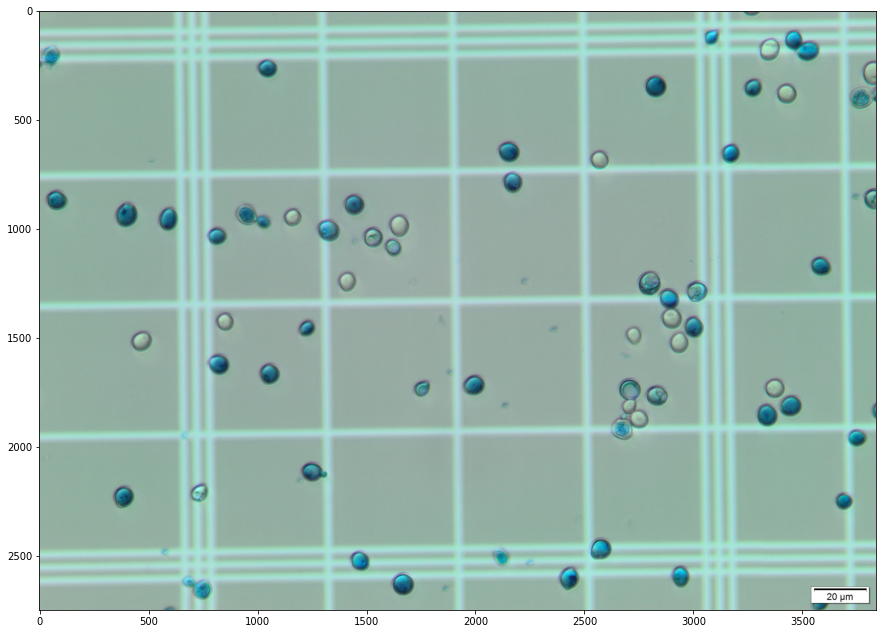

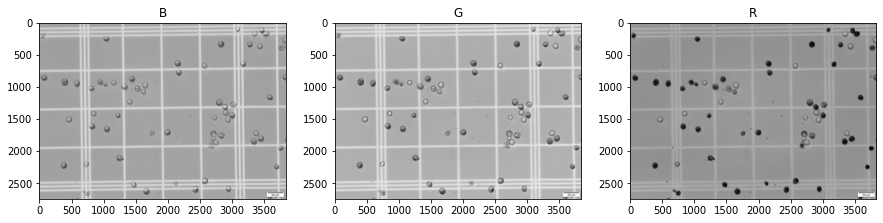

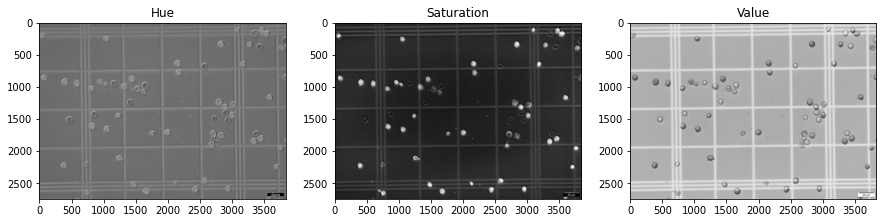

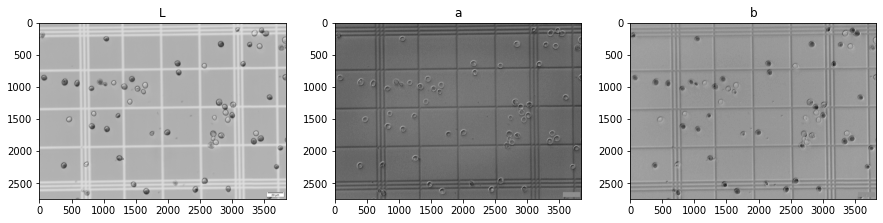

In [4]:
plt.imshow(example[:,:,::-1])
plt.show()

plt.subplot(131); plt.imshow(example[:,:,0], cmap="gray"); plt.title("B")
plt.subplot(132); plt.imshow(example[:,:,1], cmap="gray"); plt.title("G")
plt.subplot(133); plt.imshow(example[:,:,2], cmap="gray"); plt.title("R")
plt.show()

example_hsv = cv2.cvtColor(example, cv2.COLOR_BGR2HSV)
plt.subplot(231); plt.imshow(example_hsv[:,:,0], cmap="gray"); plt.title("Hue");
plt.subplot(232); plt.imshow(example_hsv[:,:,1], cmap="gray"); plt.title("Saturation")
plt.subplot(233); plt.imshow(example_hsv[:,:,2], cmap="gray"); plt.title("Value")
plt.show()

example_lab = cv2.cvtColor(example, cv2.COLOR_BGR2Lab)
plt.subplot(331); plt.imshow(example_lab[:,:,0], cmap="gray"); plt.title("L");
plt.subplot(332); plt.imshow(example_lab[:,:,1], cmap="gray"); plt.title("a")
plt.subplot(333); plt.imshow(example_lab[:,:,2], cmap="gray"); plt.title("b")
plt.show()

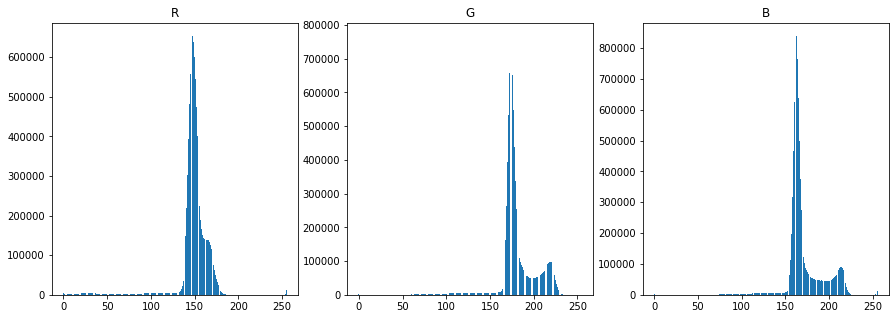

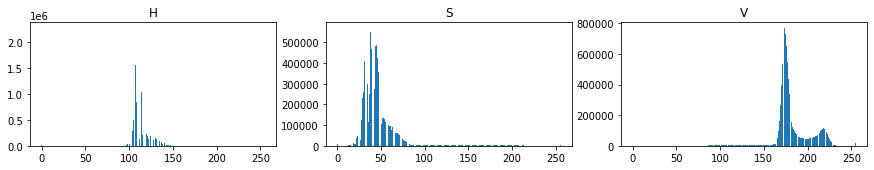

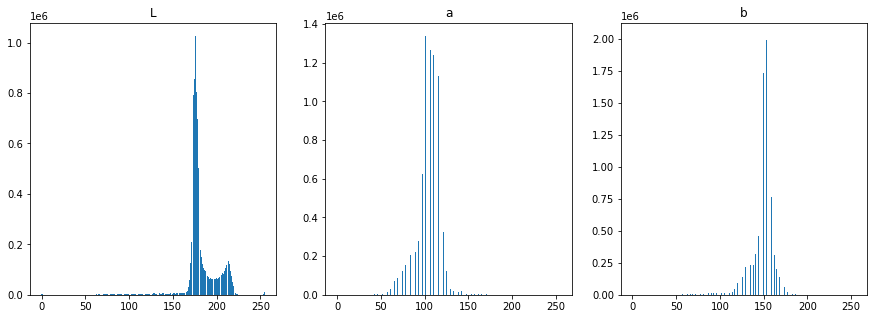

In [6]:

plt.figure(figsize=(15,5))
histB,_ = np.histogram(example[:,:,0], bins=256)
histG,_ = np.histogram(example[:,:,1], bins=256)
histR,_ = np.histogram(example[:,:,2], bins=256)

plt.subplot(131); plt.bar(range(256),histR); plt.title("R");
plt.subplot(132); plt.bar(range(256),histG); plt.title("G")
plt.subplot(133); plt.bar(range(256),histB); plt.title("B")
plt.show()

plt.figure(figsize=(15,5))
histH,_ = np.histogram(example_hsv[:,:,0], bins=256)
histS,_ = np.histogram(example_hsv[:,:,1], bins=256)
histV,_ = np.histogram(example_hsv[:,:,2], bins=256)

plt.subplot(231); plt.bar(range(256),histH); plt.title("H");
plt.subplot(232); plt.bar(range(256),histS); plt.title("S")
plt.subplot(233); plt.bar(range(256),histV); plt.title("V")
plt.show()

plt.figure(figsize=(15,5))
histL,_ = np.histogram(example_lab[:,:,0], bins=256)
hista,_ = np.histogram(example_lab[:,:,1], bins=256)
histb,_ = np.histogram(example_lab[:,:,2], bins=256)

plt.subplot(131); plt.bar(range(256),histL); plt.title("L");
plt.subplot(132); plt.bar(range(256),hista); plt.title("a")
plt.subplot(133); plt.bar(range(256),histb); plt.title("b")
plt.show()


Let's try to do some work.

In [7]:
a = perf_counter()
example_3 = np.uint8(quantize_with_kmeans(example_lab, 4))
b = perf_counter()
print("elapsed time: ",b-a)

elapsed time:  25.99255811306648


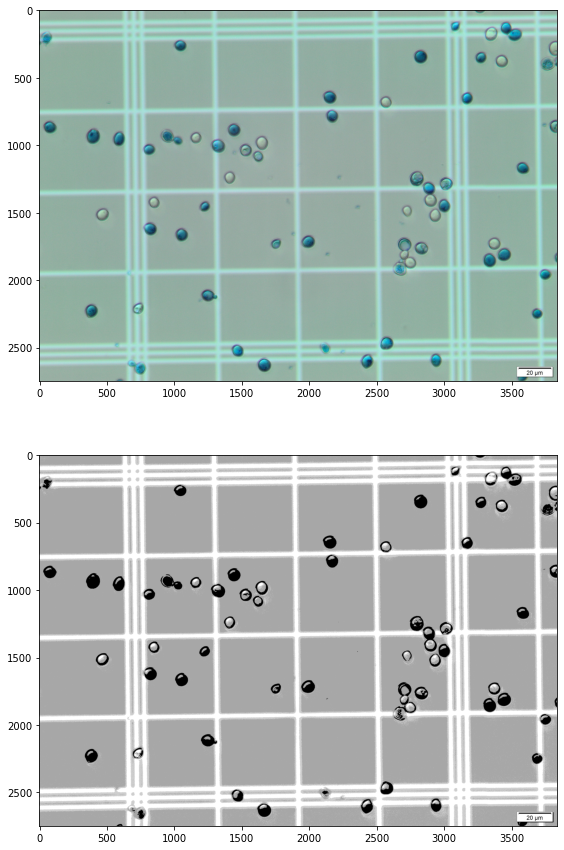

In [8]:
plt.figure(1)
plt.subplot(211)
plt.imshow(example[:,:,::-1],)
plt.subplot(212)
plt.imshow(example_3[:,:,0],cmap='gray')
plt.show()

<BarContainer object of 256 artists>

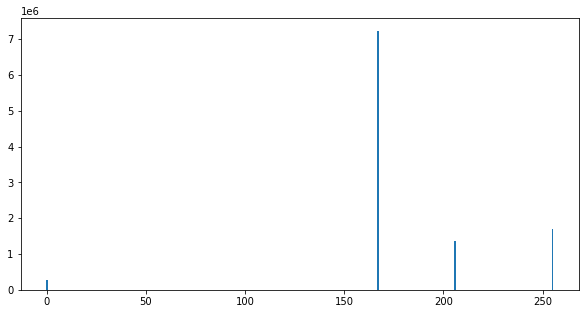

In [10]:
test_case = example_3[:,:,0]
plt.figure(figsize=(10,5))
histT,_ = np.histogram(test_case, bins=256)
plt.bar(range(256),histT)


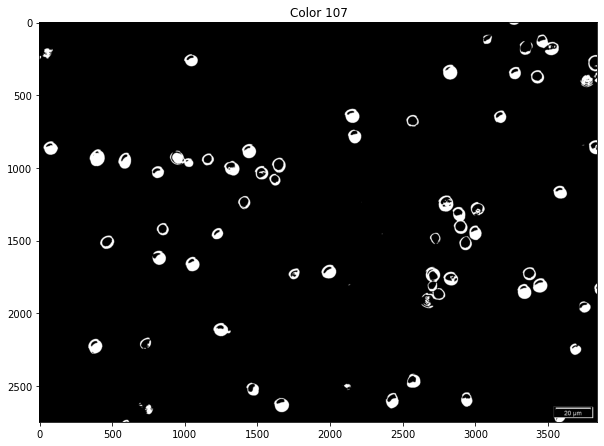

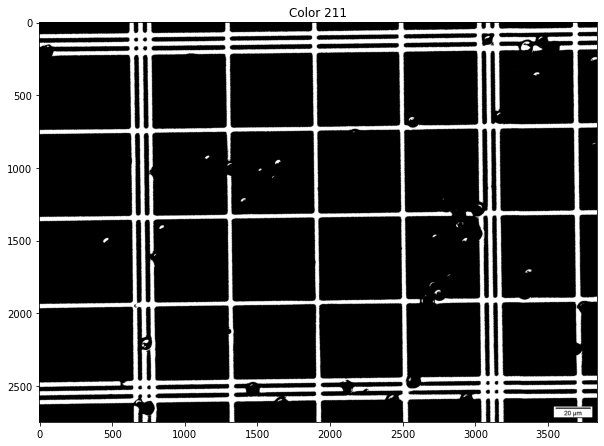

In [11]:
#InteractiveShell.ast_node_interactivity = "all"

np.unique(test_case[:,:])

values = []
for color in np.unique(test_case[:,:]):
    a = test_case.copy()
    a[ a != color ] = 0
    values.append(a[a == color].sum())
    plt.figure(figsize=(10,10))
    plt.imshow(a,cmap='gray');plt.title("Color " + str(color))


In [21]:
print(np.array([values,np.unique(test_case[:,:])]).transpose())

[[  30371415        107]
 [1264561200        175]
 [ 258555745        191]
 [ 356319076        211]]


In [49]:
counting = {np.unique(test_case[:,:])[i] : values[i]  for i in range(len(values))}

print(i)

{107: 30371415, 175: 1264561200, 191: 258555745, 211: 356319076}

In [38]:
circles_case = example.copy()
#example_hsv = cv2.GaussianBlur(example_hsv,9,)
#example_hsv = cv2.medianBlur(example_hsv,15)
#test_case = cv2.cvtColor(example, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(test_case,cv2.HOUGH_GRADIENT,2.9,60,\
                          minRadius=30, maxRadius=90)
try:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # draw the outer circle
        cv2.circle(circles_case, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # draw the center of the circle
        cv2.circle(circles_case, (i[0], i[1]), 2, (0, 0, 255), 3) 
    
except:
    print("no circles found")
plt.figure(figsize=(15,15))
plt.imshow(circles_case, cmap="gray")

In [ ]:
cv2.cvtColor(example, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(example, cv2.COLOR_BGR2GRAY), cmap='gray')

In [ ]:
#np.max(example_hsv[:,:,0])
#example_hsv = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
#example_hsv = cv2.GaussianBlur(example_hsv,9,)
#example_hsv = cv2.medianBlur(example_hsv,15)

test = example[:,:,0]
test = cv2.cvtColor(np.array(test), cv2.COLOR_RGB2BGR)
plt.imshow(test,cmap="gray")
method = cv.HOUGH_GRADIENT
dp = 4
minDist = 60
param1
param2
minRadius
maxRadius
circles = cv2.HoughCircles(test,method,3.5,60,\
                          maxRadius=90)
circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    # draw the outer circle
    cv2.circle(test, (i[0], i[1]), i[2], (0, 255, 0), 2)
    # draw the center of the circle
    cv2.circle(test, (i[0], i[1]), 2, (0, 0, 255), 3) 
        
plt.figure(figsize=(15,15))
plt.imshow(example_hsv, cmap="gray")